## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE with (1024, 2048, 4096) hidden neurons

Steps:

1. Train MSAE on spikes dataset
2. Create (topk) sae feature df
3. Create stim (meta)data df
4. Interp / autointerp

In [2]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [3]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [4]:
"""Spec some dataset info."""

session_id = 732592105
out_dir = Path(r"/nfs/nhome/live/jbhagat/mini/data/allen_data")
print(f"{out_dir.exists()=}")

out_dir.exists()=True


## Train MSAE

In [12]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# spk_cts_file = r"/nfs/nhome/live/jbhagat/mini/data/allen_data/sessions_proc/732592105/spike_counts.csv"
# counts_df = pd.read_csv(Path(spk_cts_file), index_col=0)
# spk_cts = t.from_numpy(counts_df.to_numpy()).bfloat16().to(device)
# spk_cts /= spk_cts.max()  # max normalize spike counts

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=2,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 3560/3560 [00:34<00:00, 104.62it/s, loss=0.00140,  l0_mean=24.0, l0_std=6.595582485198975, frac_dead=0.82763671875] 


In [158]:
display(counts_df)

,915957951,915957946,915958108,915958104,915958534,915958067,915958058,915958122,915958824,915958211,...,915966384,915966556,915966611,915966322,915966645,915966529,915966526,915966523,915966568,915966387
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143.15,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,2
9143.20,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,3
9143.25,1,2,0,5,0,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
9143.30,0,0,0,1,0,0,0,0,2,1,...,0,0,0,0,0,1,0,1,0,4


## Validate SAEs

In [5]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

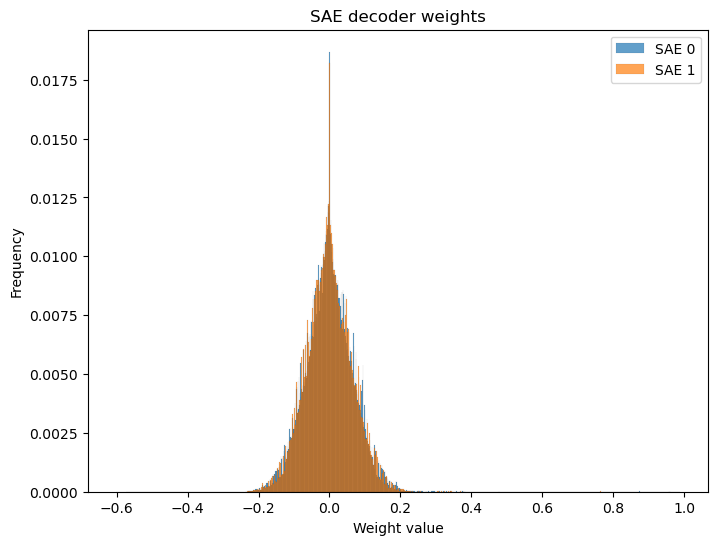

In [6]:
"""Visualize weights."""

n_inst = sae.cfg.n_instances

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 178/178 [00:00<00:00, 531.94it/s]


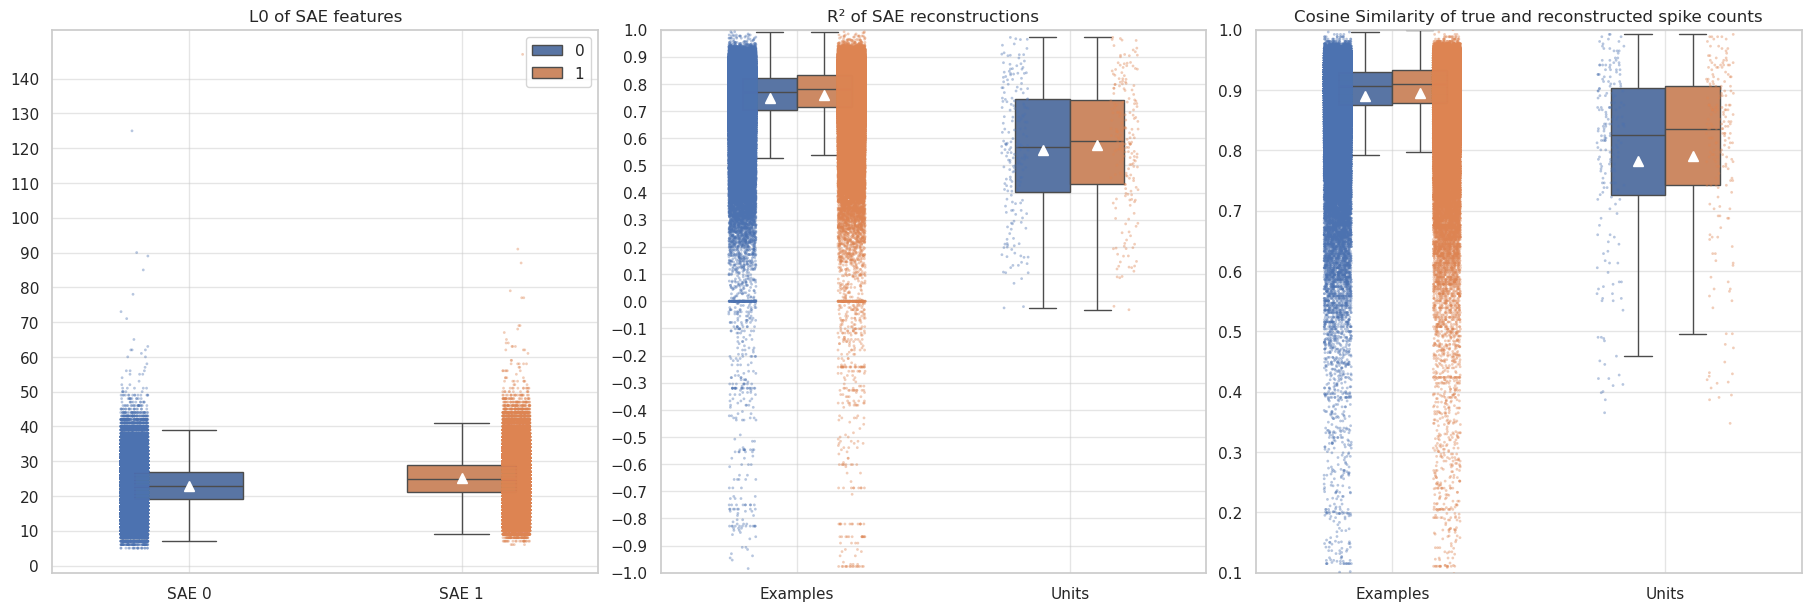

In [13]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

In [14]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.982
SAE instance 1 R² (summed spike count over all units per example) = 0.983


### Remove bad units and retrain.

In [11]:
# r2_thresh = 0.1

# inst = 0
# r2_per_unit = r2_per_unit[:, inst]

# keep_mask = r2_per_unit > r2_thresh
# print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
# print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")
# spk_cts = spk_cts[:, keep_mask]

frac units above r2_thresh=0.1: 0.88
Number to keep: 200 / 226


## Interpret features

In [16]:
"""Create dfs of feature activations."""

# Convert tensor to numpy array for easier handling
acts_array = asnumpy(topk_acts_4d)

# Create DataFrame with the data
acts_df = pd.DataFrame({
    "example_idx": acts_array[:, 0],
    "instance_idx": acts_array[:, 1],
    "feature_idx": acts_array[:, 2],
    "activation_value": acts_array[:, 3]
})

# Convert appropriate cols to ints
acts_df["example_idx"] = acts_df["example_idx"].astype(int)
acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

# Keep only features from features_df in acts_df
acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

In [ ]:
"""Visualize feature info"""

# top_n = dsae
# top_features = features_df.nlargest(top_n, "activation_count")
# plot_df = acts_df[acts_df["feature_idx"].isin(top_features["feature_idx"].tolist())]

# fig, ax = plt.subplots(figsize=(14, 8))
# sns.boxplot(x="feature_idx", y="activation_value", data=plot_df, showfliers=False, ax=ax)
# ax.set_title(f"Distributions of activation values for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Value")
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

# # Barplot of "feature on" counts
# fig, ax = plt.subplots(figsize=(14, 8))
# sns.barplot(x="feature_idx", y="activation_frac", data=features_df, ax=ax)
# ax.set_title(f"Feature activation count for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Count")
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# # ax.set_ylim(0, 0.01)
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

In [ ]:
sae_name = "sae_0.csv"

acts_df_save_path = out_dir / "sessions_proc" / f"{session_id}" / "sae_features" / sae_name
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

# acts_df.to_csv(acts_df_save_path, index=False)
acts_df = pd.read_csv(acts_df_save_path)

display(acts_df)

KeyboardInterrupt: 

In [5]:
features_df

NameError: name 'features_df' is not defined

In [19]:
"""Filter features by time active."""

bin_s = 0.05  # 50 ms sampling
tot_s = n_recon_examples * bin_s  
min_s_act = 10
max_s_act = 3600
min_frac_act = min_s_act / tot_s
max_frac_act = max_s_act / tot_s
features_df = features_df[
    (features_df["activation_frac"] >= min_frac_act)
    & (features_df["activation_frac"] <= max_frac_act)
].reset_index(drop=True)

In [24]:
features_df.sort_values("activation_mean", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
5,0,244,0.039867,0.004594,8.678282,0.001141
0,0,78,0.043293,0.004594,9.424322,0.001443
36,0,1023,0.051705,0.012876,4.015742,0.079990
116,1,865,0.051773,0.013520,3.829203,0.147318
4,0,223,0.052910,0.012034,4.396819,0.161835
...,...,...,...,...,...,...
83,1,56,0.088757,0.046050,1.927390,0.171787
31,0,906,0.092977,0.049023,1.896587,0.188411
100,1,544,0.096262,0.049440,1.947023,0.175430
11,0,401,0.122340,0.077513,1.578311,0.156645


In [25]:
features_df.sort_values("activation_std", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,78,0.043293,0.004594,9.424322,0.001443
5,0,244,0.039867,0.004594,8.678282,0.001141
4,0,223,0.052910,0.012034,4.396819,0.161835
36,0,1023,0.051705,0.012876,4.015742,0.079990
26,0,813,0.056015,0.012968,4.319549,0.127814
...,...,...,...,...,...,...
100,1,544,0.096262,0.049440,1.947023,0.175430
1,0,143,0.078292,0.049577,1.579222,0.375324
107,1,749,0.082194,0.050562,1.625596,0.173466
11,0,401,0.122340,0.077513,1.578311,0.156645


In [26]:
features_df.sort_values("act_mean_over_std", ascending=False)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,78,0.043293,0.004594,9.424322,0.001443
5,0,244,0.039867,0.004594,8.678282,0.001141
4,0,223,0.052910,0.012034,4.396819,0.161835
26,0,813,0.056015,0.012968,4.319549,0.127814
36,0,1023,0.051705,0.012876,4.015742,0.079990
...,...,...,...,...,...,...
2,0,161,0.074375,0.046619,1.595389,0.173746
29,0,857,0.077384,0.048540,1.594222,0.171601
1,0,143,0.078292,0.049577,1.579222,0.375324
11,0,401,0.122340,0.077513,1.578311,0.156645


In [82]:
features_df[features_df["feature_idx"] < 1024].sort_values("act_mean_over_std", ascending=False).head(25)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,78,0.043293,0.004594,9.424322,0.001443
5,0,244,0.039867,0.004594,8.678282,0.001141
4,0,223,0.052910,0.012034,4.396819,0.161835
26,0,813,0.056015,0.012968,4.319549,0.127814
36,0,1023,0.051705,0.012876,4.015742,0.079990
116,1,865,0.051773,0.013520,3.829203,0.147318
97,1,396,0.054730,0.014704,3.722003,0.393379
21,0,747,0.056394,0.015737,3.583525,0.204255
118,1,905,0.055886,0.015870,3.521504,0.125823
109,1,776,0.057353,0.016365,3.504687,0.363978


In [81]:
features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,78,0.043293,0.004594,9.424322,0.001443
5,0,244,0.039867,0.004594,8.678282,0.001141
36,0,1023,0.051705,0.012876,4.015742,0.079990
10,0,398,0.053927,0.015399,3.501865,0.090919
114,1,839,0.052948,0.015443,3.428667,0.089334
112,1,800,0.056453,0.016820,3.356317,0.094299
33,0,962,0.060831,0.018923,3.214633,0.069106
30,0,866,0.058732,0.018632,3.152224,0.091182
7,0,273,0.058262,0.020293,2.871092,0.075223


In [20]:
print(features_df[features_df["feature_idx"] < 256]["activation_frac"].describe())

print(features_df[features_df["feature_idx"] > 512]["activation_frac"].describe())

count    99.000000
mean      0.199465
std       0.118038
min       0.001344
25%       0.102536
50%       0.207349
75%       0.308073
max       0.394476
Name: activation_frac, dtype: float64
count    55.000000
mean      0.095419
std       0.041988
min       0.001690
25%       0.069528
50%       0.101233
75%       0.117089
max       0.199378
Name: activation_frac, dtype: float64


In [111]:
"""For each of above features, get times it fired + stim deta at these times."""

f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == 0, acts_df["feature_idx"] == 244)
]["example_idx"].values
f_ex_idxs

array([   129,  27185,  27265,  28185,  29626,  29746,  29786,  29912,
        30307,  30462,  30708,  30741,  30868,  31063,  31107,  31183,
        31428,  31513,  31627,  33542,  35453,  63515,  63524,  63528,
        67133,  67784,  67793,  67826,  68002,  68035,  68094,  68166,
        68269,  68307,  68542,  68546,  68554,  68778,  68846,  68850,
        68859,  68959,  68963,  68976,  68985,  69097,  69194,  69237,
        70781,  70785,  70902,  71976,  72043,  74013,  74040,  74081,
        74186,  74260,  74321,  74336,  74494,  74498,  74562,  74571,
        74580,  74659,  74866,  74899,  74938,  74950,  74975,  75030,
        75034,  75143,  75321,  75361,  79766,  80280,  94259,  95348,
        95740,  96417,  97289,  97722,  97901,  98003,  99023,  99920,
       100502, 100626, 100630, 100634, 100747, 100864, 100987, 101093,
       101155, 101166, 101184, 101234, 101289, 101348, 101515, 101665,
       101768, 101840, 101845, 102131, 102142, 102507, 103342, 103507,
      

In [ ]:
# For SAE features: look at unit spiking distribution / variability per feature, etc., as examples 
# of SAE feature viz

In [ ]:
# For SAE features: look at manifolds, feature activity over time (/ over stimuli xaxis bar), 
# extra: feature correlations ?

## Scratchpad below here

### Working with Allen stim metadata

In [ ]:
if out_dir.exists():
    manifest_path = out_dir / "manifest.json"
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    session_data = cache.get_session_data(session_id)
    metadata = session_data.get_stimulus_table()

out_dir.exists()=True


In [56]:
session_data.get_invalid_times()

,start_time,stop_time,tags
id,,,
0,882.52,962.56,"[EcephysProbe, 733744653, probeE]"
1,4148.40,4214.91,"[EcephysProbe, 733744653, probeE]"
2,6841.77,6923.46,"[EcephysProbe, 733744653, probeE]"
3,8843.23,8911.38,"[EcephysProbe, 733744653, probeE]"


In [55]:
"""If found, add to `metadata` df."""

running_df = session_data.running_speed
gaze_df = session_data.get_screen_gaze_data()
pupil_df = session_data.get_pupil_data()

display(running_df, gaze_df, pupil_df)

This ecephys session '732592105' has no eye tracking data. (NWB error: "'raw_gaze_mapping' not found in processing of NWBFile 'root'.")
This ecephys session '732592105' has no eye tracking data. (NWB error: "'eye_tracking' not found in processing of NWBFile 'root'.")


,start_time,end_time,velocity
0,21.55,21.55,57.028193
1,21.55,21.60,42.648001
2,21.60,21.60,48.360187
3,21.60,21.65,45.849774
4,21.65,21.65,42.937207
...,...,...,...
365061,9203.30,9203.30,10.729123
365062,9203.30,9203.30,6.948824
365063,9203.35,9203.35,9.964667
365064,9203.35,9203.35,10.639588


None

None

In [65]:
"""Reformat `metadata` df."""

metadata["start_time"] = round(metadata["start_time"] / bin_s) * bin_s
metadata["stop_time"] = round(metadata["stop_time"] / bin_s) * bin_s

init_vis_time = metadata.iloc[0]["start_time"]
new_init_vis_idx = int(init_vis_time / bin_s) + 1

time_range = np.arange(0, metadata.iloc[-1]["stop_time"] + bin_s, bin_s)
time_df = pd.DataFrame({"time": pd.Series(time_range).round(2)})

# Create a new dataframe with just the time points
time_df["start_time"] = time_df["time"]
time_df["stop_time"] = time_df["time"] + 0.05
time_df["duration"] = 0.05

# Merge the time_df with metadata
metadata = pd.merge_asof(
    time_df.sort_values("time"),
    metadata.sort_values("start_time"),
    left_on="time",
    right_on="start_time",
    direction="backward"
)

# Merge running velocity data
running_df = session_data.running_speed
running_df["start_time"] = round(running_df["start_time"] / bin_s) * bin_s
running_df["end_time"] = round(running_df["end_time"] / bin_s) * bin_s
running_df = running_df.rename(columns={"start_time": "time"})

metadata = pd.merge_asof(
    metadata.reset_index(),  # Reset index to get "time" as a column
    running_df[["time", "velocity"]].sort_values("time"),
    on="time",
    direction="backward"
)

# Clean up
metadata = (metadata.
    set_index("time")
    .drop(columns=["start_time_x", "stop_time_x", "duration_x", "index"])
    .rename(columns={"start_time_y": "start_time", "stop_time_y": "stop_time", "duration_y": "duration"})
)

metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_condition_id"] = -1
metadata["stimulus_condition_id"] = metadata["stimulus_condition_id"].astype(int)
metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_name"] = ""

metadata.loc[metadata.index[0:new_init_vis_idx], "start_time"] = 0
metadata.loc[metadata.index[0:new_init_vis_idx], "stop_time"] = init_vis_time
metadata["duration"] = metadata["stop_time"] - metadata["start_time"]

first_cols = [
    "stimulus_condition_id",
    "stimulus_name",
    "stimulus_block"
    "start_time",
    "stop_time",
    "duration",
    "orientation",
    "temporal_frequency",
    "spatial_frequency",
    "contrast",
    "x_position",
    "y_position"
]
other_cols = metadata.columns.difference(first_cols).tolist()
metadata = metadata.reindex(columns=(first_cols + other_cols))
metadata = metadata.iloc[0:n_recon_examples].reset_index(drop=True)

display(metadata)

,stimulus_condition_id,stimulus_name,stimulus_blockstart_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,size,start_time,stimulus_block,velocity
0,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
1,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
2,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
3,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
4,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182267,4868,static_gratings,NaN,9113.40,0.25,90.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",9113.15,14.0,36.989820
182268,4812,static_gratings,NaN,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",9113.40,14.0,40.996334
182269,4812,static_gratings,NaN,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",9113.40,14.0,32.010603
182270,4812,static_gratings,NaN,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",9113.40,14.0,40.645345


In [67]:
csv_path = out_dir / "sessions_proc" / f"{session_id}" / "metadata.csv"
metadata.to_csv(csv_path, index=False)

In [120]:
stim_epochs = session_data.get_stimulus_epochs()
stim_epochs["start_idx"] = (stim_epochs["start_time"] / bin_s).astype(int)
stim_epochs["stop_idx"] = (stim_epochs["stop_time"] / bin_s).astype(int)
display(stim_epochs)

,start_time,stop_time,duration,stimulus_name,stimulus_block,start_idx,stop_idx
0,21.579074,81.645874,60.066800,spontaneous,null,431,1632
1,81.645874,993.641120,911.995246,gabors,0.0,1632,19872
2,993.641120,1282.632614,288.991494,spontaneous,null,19872,25652
3,1282.632614,1581.132147,298.499533,flashes,1.0,25652,31622
4,1581.132147,1582.883624,1.751477,spontaneous,null,31622,31657
5,1582.883624,2182.384626,599.501001,drifting_gratings,2.0,31657,43647
6,2182.384626,2213.410564,31.025939,spontaneous,null,43647,44268
7,2213.410564,2813.912284,600.501720,natural_movie_three,3.0,44268,56278
8,2813.912284,2843.937384,30.025100,spontaneous,null,56278,56878
9,2843.937384,3144.221564,300.284180,natural_movie_one,4.0,56878,62884


In [ ]:
metadata["stimulus_name"].unique()

array(['spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes'], dtype=object)

In [168]:
session_data.get_stimulus_parameter_values()

{'frame': array([0.0, 1.0, 2.0, ..., 3598.0, 3599.0, -1.0], dtype=object),
 'color': array([-1.0, 1.0], dtype=object),
 'temporal_frequency': array([4.0, 15.0, 8.0, 1.0, 2.0], dtype=object),
 'phase': array(['[3644.93333333, 3644.93333333]', '[0.0, 0.0]',
        '[10605.96666667, 10605.96666667]', '0.0', '0.25', '0.5', '0.75'],
       dtype=object),
 'size': array(['[20.0, 20.0]', '[300.0, 300.0]', '[250.0, 250.0]',
        '[1920.0, 1080.0]'], dtype=object),
 'orientation': array([45.0, 90.0, 0.0, 225.0, 270.0, 180.0, 315.0, 135.0, 30.0, 150.0,
        60.0, 120.0], dtype=object),
 'y_position': array([-20.0, -10.0, 30.0, -40.0, 10.0, 20.0, 40.0, -30.0, 0.0],
       dtype=object),
 'contrast': array([0.8, 1.0], dtype=object),
 'x_position': array([-30.0, 20.0, 40.0, 30.0, -40.0, -10.0, 10.0, 0.0, -20.0],
       dtype=object),
 'spatial_frequency': array(['0.08', '[0.0, 0.0]', '0.04', 0.32, 0.08, 0.16, 0.04, 0.02],
       dtype=object)}

In [114]:
metadata.iloc[f_ex_idxs]["stimulus_name"].unique()

array(['', 'flashes', 'spontaneous', 'drifting_gratings',
       'static_gratings', 'natural_scenes', 'natural_movie_one'],
      dtype=object)

In [117]:
# f_ex_idxs.shape
# start_idx = 2000
# metadata.iloc[f_ex_idxs][start_idx : start_idx + 200]
# plt.scatter(np.arange(0, 1000), metadata.iloc[f_ex_idxs].index[0:1000], marker=".", s=1)

feat_metadata = metadata.iloc[f_ex_idxs]
feat_metadata

# Filter by if "grating" in stimulus_name
# feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]


,stimulus_condition_id,stimulus_name,stimulus_blockstart_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,size,start_time,stimulus_block,velocity
129,-1,,NaN,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
27185,244,flashes,NaN,1358.95,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,-1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1358.70,1.0,-2.347975
27265,244,flashes,NaN,1362.95,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,-1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1362.70,1.0,0.246538
28185,245,flashes,NaN,1409.00,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1408.75,1.0,1.704919
29626,244,flashes,NaN,1481.05,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,-1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1480.80,1.0,-2.371895
29746,244,flashes,NaN,1487.05,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,-1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1486.80,1.0,1.097339
29786,245,flashes,NaN,1489.05,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1488.80,1.0,0.023331
29912,244,flashes,NaN,1495.05,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,-1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1494.80,1.0,-1.144085
30307,245,flashes,NaN,1515.10,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1514.85,1.0,1.628585
30462,245,flashes,NaN,1523.10,0.25,0.0,null,"[0.0, 0.0]",0.8,null,null,1.0,null,"[0.0, 0.0]","[300.0, 300.0]",1522.85,1.0,-0.934389


In [123]:
feat_metadata[feat_metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

array([4914, 4909, 4935, 4955, 4991, 4926, 5024, 4953, 4967, 4932, 4922,
       4933, 4997, 4966, 4976, 5005, 4974, 4993, 4908, 4945, 4980, 4936,
       4951, 5008, 5013, 4999, 5018, 4934, 4939, 4986, 5017, 4931, 4930,
       5023, 4985, 5020, 5012, 5011])

In [147]:
acts_df_out_path = out_dir / "sessions_proc" / f"{session_id}" / "sae_features" / "sae_0.csv"
acts_df_out_path.parent.mkdir(parents=True, exist_ok=True)
acts_df.to_csv(acts_df_out_path, index=False)

## Features found

### Possible

High-level:
  
  - Flashes
  - Drifting gratings (motion)
  - Movies (motion)
  - Static gratings

Low-level:
  - Drifting gratings:
    - Orientation
    - Temporal frequency
    - Visual field position / size

### Actual

#### Session 732592105

##### sae_0

- 0 : 244

  - flashes, gratings / gabors, and (subset) of natural scenes at low running velocity

## Scratchpad 2

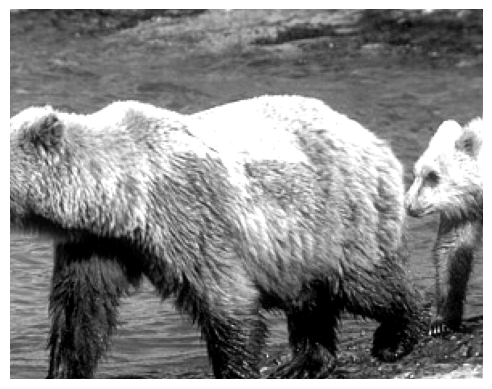

In [140]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [126]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

array([4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918,
       4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929,
       4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940,
       4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951,
       4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962,
       4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973,
       4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984,
       4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995,
       4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006,
       5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017,
       5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026])

In [127]:
session_data.stimulus_presentations

,stimulus_block,start_time,stop_time,contrast,spatial_frequency,phase,x_position,frame,color,y_position,size,temporal_frequency,stimulus_name,orientation,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,21.579074,81.645874,null,null,null,null,null,null,null,null,null,spontaneous,null,60.066800,0
1,0.0,81.645874,81.879397,0.8,0.08,"[3644.93333333, 3644.93333333]",-30.0,null,null,-20.0,"[20.0, 20.0]",4.0,gabors,45.0,0.233523,1
2,0.0,81.879397,82.129600,0.8,0.08,"[3644.93333333, 3644.93333333]",20.0,null,null,-10.0,"[20.0, 20.0]",4.0,gabors,90.0,0.250203,2
3,0.0,82.129600,82.379803,0.8,0.08,"[3644.93333333, 3644.93333333]",40.0,null,null,30.0,"[20.0, 20.0]",4.0,gabors,90.0,0.250203,3
4,0.0,82.379803,82.630006,0.8,0.08,"[3644.93333333, 3644.93333333]",40.0,null,null,-40.0,"[20.0, 20.0]",4.0,gabors,45.0,0.250203,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70383,14.0,9142.164805,9142.415016,0.8,0.04,0.75,null,null,null,null,"[250.0, 250.0]",null,static_gratings,60.0,0.250210,4806
70384,14.0,9142.415016,9142.665223,0.8,0.08,0.0,null,null,null,null,"[250.0, 250.0]",null,static_gratings,30.0,0.250207,4857
70385,14.0,9142.665223,9142.915430,0.8,0.32,0.75,null,null,null,null,"[250.0, 250.0]",null,static_gratings,60.0,0.250207,4876


In [ ]:
# session_data.presentationwise_spike_times()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
21.579087,0,915959976,0.000013
21.579387,0,915965400,0.000313
21.579587,0,915959890,0.000513
21.579787,0,915960262,0.000713
21.579961,0,915958751,0.000887
...,...,...,...
9143.415088,70387,915959974,0.249451
9143.415170,70387,915964551,0.249533
9143.415255,70387,915959708,0.249618


In [ ]:
# session_data.conditionwise_spike_statistics()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
915956282,0,6759,15,450.600000,617.813518,159.518764
915956304,0,10492,15,699.466667,1009.571187,260.670160
915956340,0,11240,15,749.333333,950.352316,245.379913
915956345,0,13776,15,918.400000,1291.497072,333.463110
915956349,0,22881,15,1525.400000,2196.381954,567.103382
...,...,...,...,...,...,...
915966905,5026,4,50,0.080000,0.444467,0.062857
915966931,5026,14,50,0.280000,0.858095,0.121353
915966963,5026,0,50,0.000000,0.000000,0.000000
